#### Problem statement: Develop a model that is able to process the feed/stream from a mounted/fixed camera(like CCTV) and able to detect in real time if the camera is pointed somewhere else. To implement this you may record a video from your mobile camera and then change is to some other angle after a while. Also the model should not confuse of moving people, if any, in the frame to be a valid detection

#### performance metrics : binary_logloss,confusion matrix

In [2]:
import cv2
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Input,Flatten,Dense
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.metrics import roc_curve,auc

### data loading

In [3]:
## loading data
first_cam_no = np.load('dataset_images/first_cam_no.npy')
first_cam_yes = np.load('dataset_images/first_cam_yes.npy')
second_cam_no = np.load('dataset_images/second_cam_no.npy')
second_cam_yes = np.load('dataset_images/second_cam_yes.npy')
third_cam_no = np.load('dataset_images/third_cam_no.npy')
third_cam_yes = np.load('dataset_images/third_cam_yes.npy')
forth_cam_no = np.load('dataset_images/forth_cam_no.npy')
forth_cam_yes = np.load('dataset_images/forth_cam_yes.npy')
dataset_no =  [first_cam_no,second_cam_no,third_cam_no,forth_cam_no]
dataset_yes =  [first_cam_yes,second_cam_yes,third_cam_yes,forth_cam_yes]
main_images = [first_cam_no[15],second_cam_no[15],third_cam_no[15],forth_cam_no[15]]

In [4]:
def prepare(main_image,images,label):
    final_images = np.empty_like(images)
    #for i in tqdm(range(len(images))):
    #    final_images[i] = main_image-images[i]
    final_images = images
    return final_images,np.array([label]*len(images))            #adding labels to each point

In [5]:
## adding all cc cam rec
X = None
y = None
for i in range(len(dataset_no)):
    temp1,temp2 = prepare(main_images[i],dataset_no[i],0)
    temp3,temp4 = prepare(main_images[i],dataset_yes[i],1)
    if X is not None:
        X = np.vstack([X,temp1,temp3])
        y = np.hstack([y,temp2,temp4])
    else:
        X = np.vstack([temp1,temp3])
        y = np.hstack([temp2,temp4])
image_number = np.array([0]*122 + [1]*122 +[2]*122 +[3]*122)
y= np.hstack([y.reshape(-1,1),image_number.reshape(-1,1)])

In [6]:
X.shape

(488, 480, 640, 3)

In [7]:
y.shape

(488, 2)

### train test split

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=23)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size=0.15,random_state=23)

### data augumentations

In [9]:
aug1 = iaa.GaussianBlur(sigma=(0.0, 3.0))
aug2 = iaa.MotionBlur(k=15)
aug3 = iaa.WithColorspace(
    to_colorspace="HSV",
    from_colorspace="RGB",
    children=iaa.WithChannels(
        0,
        iaa.Add((0, 50))
    )
)
aug4 = iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True)
aug5 = iaa.Grayscale(alpha=(0.0, 1.0))
aug6 = iaa.ChangeColorTemperature((1100, 10000))
aug7 = iaa.GammaContrast((0.5, 2.0), per_channel=True)
aug8 = iaa.LogContrast(gain=(0.6, 1.4), per_channel=True)
aug9 = iaa.AllChannelsCLAHE(clip_limit=(1, 10))
aug10 = iaa.Clouds()
aug11 = iaa.Fog()
aug12 = iaa.Rain(speed=(0.1, 0.3))

### data loaded

In [10]:
class Dataset:

    def __init__(self, X, y):
        self.X=X
        self.y=y

    
    def __getitem__(self, i):
        
        # read data
        image = self.X[i]
        
        if bool(np.random.randint(2)):
                image = aug1.augment_image(image)
        if bool(np.random.randint(2)):
                image = aug2.augment_image(image)
        if bool(np.random.randint(2)):
                image = aug3.augment_image(image)        
        if bool(np.random.randint(2)):
                image = aug4.augment_image(image)      
        if bool(np.random.randint(2)):
                image = aug5.augment_image(image)      
        if bool(np.random.randint(2)):
                image = aug6.augment_image(image)     
        if bool(np.random.randint(2)):
                image = aug7.augment_image(image)      
        if bool(np.random.randint(2)):
                image = aug8.augment_image(image)      
        if bool(np.random.randint(2)):
                image = aug9.augment_image(image)      
        """if bool(np.random.randint(2)):
                image = aug10.augment_image(image)      
        if bool(np.random.randint(2)):
                image = aug11.augment_image(image)      
        if bool(np.random.randint(2)):
                image = aug12.augment_image(image)   """  
        image = main_images[self.y[i][1]] - image 
            
        return image, self.y[i][0]
        
    def __len__(self):
        return len(self.X)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.dataset) // self.batch_size

In [11]:
train_dataloder = Dataloder(Dataset(X_train,y_train))
cv_dataloder = Dataloder(Dataset(X_cv,y_cv))
test_dataloder = Dataloder(Dataset(X_test,y_test))

### transfer learning 

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(480,640,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

### model training 

In [13]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
model_check=ModelCheckpoint('model.h5',save_best_only=True,verbose=3)

%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 
%tensorboard --logdir './logs' --host "0.0.0.0" --port 6006
from tensorflow.keras.callbacks import TensorBoard
tensorboard_callback=TensorBoard('./logs',histogram_freq=1)
early_stop=EarlyStopping(monitor='val_loss',patience=3)
callbacks = [tensorboard_callback,model_check,early_stop]

In [14]:
input_layer = Input(shape=X[0].shape)
output = base_model(input_layer)
fla = Flatten()(output)
final_output = Dense(1, activation='sigmoid')(fla)
m = Model(inputs=input_layer,outputs = final_output)
m.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC'])

In [15]:
m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 15, 20, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 384000)            0         
                                                                 
 dense (Dense)               (None, 1)                 384001    
                                                                 
Total params: 2,641,985
Trainable params: 384,001
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
h = m.fit(train_dataloder,validation_data=cv_dataloder,epochs=10,callbacks = callbacks)

Epoch 1/10
351/351 [==============================] - ETA: 0s - loss: 6.8971 - accuracy: 0.7692 - auc: 0.7820
Epoch 1: val_loss improved from inf to 0.72175, saving model to model.h5
351/351 [==============================] - 60s 162ms/step - loss: 6.8971 - accuracy: 0.7692 - auc: 0.7820 - val_loss: 0.7218 - val_accuracy: 0.9683 - val_auc: 0.9682
Epoch 2/10
351/351 [==============================] - ETA: 0s - loss: 4.3238 - accuracy: 0.8718 - auc: 0.8821
Epoch 2: val_loss did not improve from 0.72175
351/351 [==============================] - 54s 155ms/step - loss: 4.3238 - accuracy: 0.8718 - auc: 0.8821 - val_loss: 4.1311 - val_accuracy: 0.8889 - val_auc: 0.8871
Epoch 3/10
351/351 [==============================] - ETA: 0s - loss: 2.3592 - accuracy: 0.9345 - auc: 0.9414
Epoch 3: val_loss did not improve from 0.72175
351/351 [==============================] - 61s 172ms/step - loss: 2.3592 - accuracy: 0.9345 - auc: 0.9414 - val_loss: 0.8162 - val_accuracy: 0.9524 - val_auc: 0.9521
Epoch

In [17]:
m.save('model/cnn.h5')

In [18]:
m.evaluate(test_dataloder)

74/74 [==============================] - 9s 125ms/step - loss: 2.9270 - accuracy: 0.9189 - auc: 0.9181


[2.9270341396331787, 0.9189189076423645, 0.9181286096572876]

In [ ]:
pred

74/74 [==============================] - 9s 118ms/step


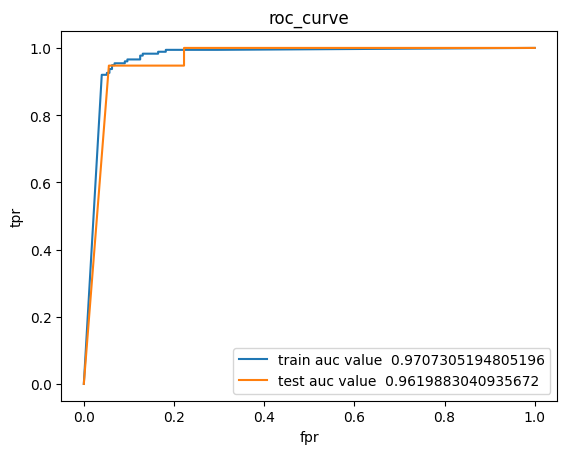

In [23]:
predict_train = m.predict(train_dataloder).reshape(-1,1)
predict_test = m.predict(test_dataloder).reshape(-1,1)
fpr,tpr,thres=roc_curve(y_train[:,0],predict_train)
plt.plot(fpr,tpr,label='train auc value  {}'.format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
#plt.title('roc_curve for train')
fpr,tpr,thres=roc_curve(y_test[:,0],predict_test)
plt.plot(fpr,tpr,label='test auc value  {}'.format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('roc_curve')
plt.show()

In [25]:
def best_threshold(fpr,tpr,thres):
    return thres[np.argmax(tpr*(1-fpr))]
def after_best_threshold(x,thres):
    label=[ ]
    for i in x:
        if i<thres:
            label.append(0)
        else:
            label.append(1)
    return label
fpr,tpr,thres=roc_curve(y_train[:,0],predict_train)
b=best_threshold(fpr,tpr,thres)

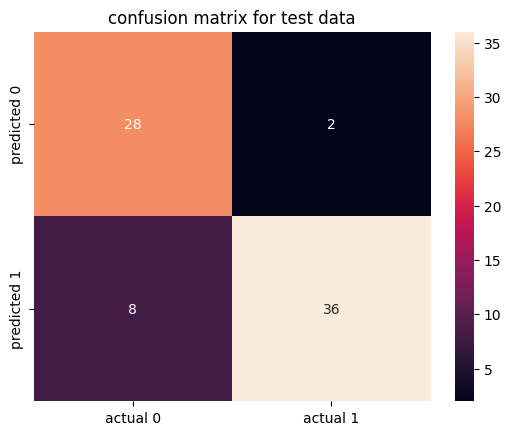

In [27]:
from sklearn.metrics import confusion_matrix
predict_test_after_best_thresh=after_best_threshold(predict_test,b)
cm=confusion_matrix(y_test[:,0],predict_test_after_best_thresh).T
temp=pd.DataFrame(data=cm,columns=['actual 0','actual 1'],index=['predicted 0','predicted 1'])
sns.heatmap(temp,annot=True,fmt='d')
plt.title('confusion matrix for test data')
plt.show()

### Results :

got accurcay 0.9 ,but dataset was too small